Manuel Aragon
ma1162

The following notebook creates tic tac toe players using a q-learning reinforcement learning strategy

In [3]:
import random
import matplotlib 
import numpy as np 
from collections import defaultdict 

In [4]:
class BoardEnvironment:
  """ this class creates an environment for agents to interact with"""

  def __init__(self):
    "initialize board"
  
  def set_players(self, playerA, playerB):
    " connects players with the environment "
    self.playerA = playerA
    self.playerB = playerB
    self.reset() # defines current_player
      
  def reset(self):
    self.turn = 'X' # the board always starts with X, regardless of which player

    # board states are a 9-character representing the state of the board.
    self.board = list('---------')  
    if (self.playerA and self.playerB): # if they are set
      self.playerA.reset_past()
      self.playerB.reset_past()
      if (random.random() < 0.5):  # randomly pick the player to start
        self.current_player = self.playerA
      else:
        self.current_player = self.playerB 

  def print_board(self, board_string = None):
    "print more readable board either from supplied board string or the current board"
    if not board_string:
      B = self.board
    else:
      B = board_string
    print(B[0],'|', B[1],'|', B[2], sep='')
    print('-----')
    print(B[3],'|', B[4],'|', B[5], sep='')
    print('-----')
    print(B[6],'|', B[7],'|', B[8], sep='')

  def get_state(self):
    return "".join(self.board)
  
  def other_player(self):
    # note, returns other player even if playerA is playing itself
    if (self.current_player == self.playerA):
      return self.playerB 
    else:
      return self.playerA  
    
  def available_actions(self):
    return [ind for ind, val in enumerate(self.board) if val == '-']

  def play_game(self): 
    # returns the winning player or None if a tie
    self.reset()
    while (not self.is_full() ):
      choice = self.current_player.select_action()

      self.board[choice] = self.turn # should check if valid

      if self.winner(self.turn):
        self.current_player.reward(100)
        self.other_player().reward(-100)
        return self.current_player
      else: # no one has won yet
        self.other_player().reward(0)

      # switch players
      self.turn = 'X' if self.turn == 'O' else 'O' # switch turn
      self.current_player = self.other_player()
    # it's a tie  
    return None
        
  def winner(self, check_for = ['X','O']):
    straight_lines = ((0,1,2),(3,4,5),(6,7,8),(0,3,6),
                      (1,4,7),(2,5,8),(0,4,8),(2,4,6))
    for turn in check_for:
        for line in straight_lines:
            if all(x == turn for x in (self.board[i] for i in line)):
                return turn
    return '' # if there is no winner

  def is_full(self):
    return('-' not in self.board) 

In [5]:
class Agent:
    """ this class is a generic Q-Learning reinforcement learning agent for discrete states and fixed actions
    represented as strings"""
    def __init__(self, environment, policy = 'max', learning_rate = 0.5, discount_factor = 0.95, epsilon = 0.01):
        if policy in ['max', 'random', 'epsilon']:
          self.policy = policy
        else:
          raise InputError(policy, ' is not an available policy')
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.Q = defaultdict(lambda: 0.0) # stores (state, action) value tuples as keys
        self.environment = environment
        self.epsilon = epsilon # Fraction of time making a random choice for epsilon policy
        self.reset_past()

    def reset_past(self):
      self.past_action = None
      self.past_state = None
          
    def select_action(self):
      available_actions = self.environment.available_actions()
      if (self.policy == 'random') or (self.policy == 'epsilon' and random.random() < self.epsilon):
        choice = random.choice(available_actions)
      else: #self.policy == 'max' or it's an epsilon policy determined to pick the max
        Q_vals = [self.Q[(self.environment.get_state(), x)] for x in available_actions]
        #randomly pick one of the maximum values
        max_val = max(Q_vals) # will often be 0 in the beginning
        max_pos = [i for i, j in enumerate(Q_vals) if j == max_val]
        max_indices = [available_actions[x] for x in max_pos]
        choice = random.choice(max_indices)
      self.past_state = self.environment.get_state()
      self.past_action = choice
      return choice
        
    def reward(self, reward_value):
        # finding the best expected reward
        available_actions = self.environment.available_actions()
        next_Q_vals = [self.Q[(self.environment.get_state(), x)] for x in available_actions]
        max_next_Q = max(next_Q_vals) if next_Q_vals else 0 # will often be 0 in the beginning
        td_target = reward_value + self.discount_factor * max_next_Q
        reward_pred_error = td_target - self.Q[(self.past_state,self.past_action)]
        #if (self.past_state or self.past_action):
        self.Q[(self.past_state,self.past_action)] += self.learning_rate * reward_pred_error

In [6]:
class RepeatedGames:
    def __init__(self, environment, playerA, playerB):
        self.environment = environment
        self.playerA = playerA
        self.playerB = playerB
        self.reset_history()
    
    def reset_history(self):
        self.history = []
    
    def play_game(self):
        self.environment.reset()
        winner = self.environment.play_game()
        if (winner == self.playerA):
          self.history.append('A')
        elif (winner == self.playerB):
          self.history.append('B')
        else:
          self.history.append('-')
    
    def play_games(self, games_to_play):
        for i in range(games_to_play):
            self.play_game()
        print(self.history[-games_to_play:].count('A'),'games won by player A')
        print(self.history[-games_to_play:].count('B'),'games won by player B')
        print(self.history[-games_to_play:].count('-'),'ties')

The above code was left as is.
The tournaments with different policies are below one after the other and discussion of the results is at the end of each results.

47 games won by player A
43 games won by player B
10 ties

7886 games won by player A
1263 games won by player B
851 ties

86 games won by player A
3 games won by player B
11 ties

highest Q for player A: 100.0 , state_action: ('--OX-X--O', 4)
-|-|O
-----
X|-|X
-----
-|-|O

highest Q for player B: 99.609375 , state_action: ('-OXXXOOOX', 0)
-|O|X
-----
X|X|O
-----
O|O|X

lowest Q for player A: -93.75 , state_action: ('OX--XXXOO', 2)
O|X|-
-----
-|X|X
-----
X|O|O

lowest Q for player B: -100.0 , state_action: ('---X-X--O', 0)
-|-|-
-----
X|-|X
-----
-|-|O


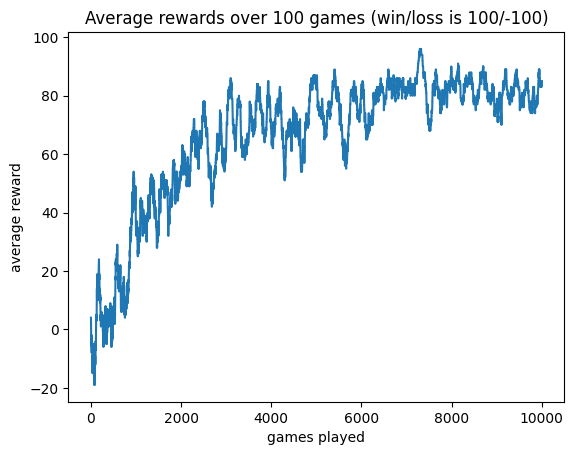

In [7]:
# max vs random
board = BoardEnvironment()
A = Agent(board, 'max')
B = Agent(board, 'random')
board.set_players(A, B)

tournament = RepeatedGames(board, A, B)

# 1. Have them play 100 times (observe behavior prior to learning)
tournament.play_games(100)

# a. Then print how often each player wins or ties in these 100 games.
print()

# 2. Have them play 10,000 times.
tournament.play_games(10000)
print()

# a. Display a running average of the rewards player A receives.
import numpy as np
import pylab as py
import matplotlib
%matplotlib inline

history = np.array(tournament.history.copy())
rewards = np.zeros(len(history))
rewards[history == 'A'] = 100
rewards[history == 'B'] = -100

def running_mean(x, N):
    return np.convolve(x, np.ones((N,))/N, mode='valid')
r_mean = running_mean(rewards, 100)
py.plot(r_mean)
py.xlabel('games played')
py.ylabel('average reward')
py.title('Average rewards over 100 games (win/loss is 100/-100)')

# 3. Have them play 100 more times
tournament.play_games(100)

# a. Then print how often each player wins or ties in these 100 games
print()

# observe the highest and lowest board state action value functions
key_max = max(A.Q.keys(), key=(lambda k: A.Q[k]))
print("highest Q for player A:", A.Q[key_max],', state_action:', key_max)
board.print_board(key_max[0])
key_max = max(B.Q.keys(), key=(lambda k: B.Q[k]))
print("\nhighest Q for player B:", B.Q[key_max],', state_action:', key_max)
board.print_board(key_max[0])
key_min = min(A.Q.keys(), key=(lambda k: A.Q[k]))
print("\nlowest Q for player A:", A.Q[key_min],', state_action:', key_min)
board.print_board(key_min[0])
key_min = min(B.Q.keys(), key=(lambda k: B.Q[k]))
print("\nlowest Q for player B:", B.Q[key_min],', state_action:', key_min)
board.print_board(key_min[0])


Discussion for max vs random

In the max vs. random tournament in Tic Tac Toe, player A (using the max policy) consistently outperformed player B (using the random policy). While player B won 30 games in the first 100 games, over the course of 10,000 games, player A won the majority (7498) of games, and player B only won a small fraction (1273). Additionally, player A won 80 games and player B only won 5 games in the final 100 games, indicating the effectiveness of the learned strategy of player A. These results highlight the importance of a strong policy and the effectiveness of reinforcement learning in games with relatively small state spaces like Tic Tac Toe.

The state-action pairs provide insights into the learned strategies of players A and B. The highest Q-values for players A and B correspond to well-known winning strategies in Tic Tac Toe, while the lowest Q-values indicate situations where the players have not yet learned effective strategies. Additionally, the reward graph showed that the average reward increased and eventually plateaued around 75-80%, suggesting that the players had learned effective strategies and further learning was no longer necessary.

44 games won by player A
40 games won by player B
16 ties

4454 games won by player A
4297 games won by player B
1249 ties

44 games won by player A
44 games won by player B
12 ties

highest Q for player A: 99.99961853027344 , state_action: ('OOXXOOX-X', 7)
O|O|X
-----
X|O|O
-----
X|-|X

highest Q for player B: 99.993896484375 , state_action: ('XOXOXXOO-', 8)
X|O|X
-----
O|X|X
-----
O|O|-

lowest Q for player A: -99.21875 , state_action: ('X-XO-OXXO', 1)
X|-|X
-----
O|-|O
-----
X|X|O

lowest Q for player B: -99.609375 , state_action: ('XX-O-XOXO', 2)
X|X|-
-----
O|-|X
-----
O|X|O


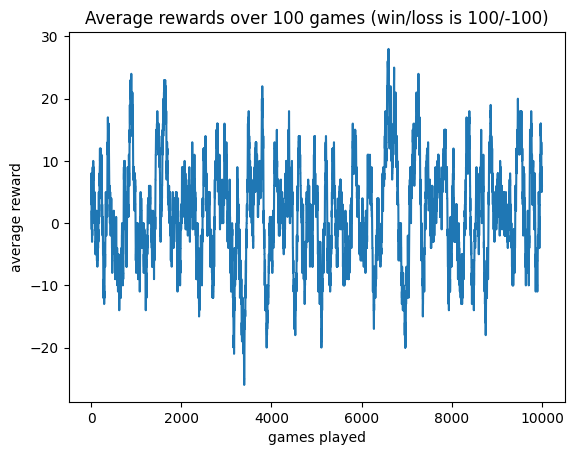

In [8]:
# random vs random
board = BoardEnvironment()
A = Agent(board, 'random')  # Change this line to make player A use the 'random' strategy
B = Agent(board, 'random')
board.set_players(A, B)

tournament = RepeatedGames(board, A, B)

# 1. Have them play 100 times (observe behavior prior to learning)
tournament.play_games(100)

# a. Then print how often each player wins or ties in these 100 games.
print()

# 2. Have them play 10,000 times.
tournament.play_games(10000)
print()

# a. Display a running average of the rewards player A receives.
import numpy as np
import pylab as py
import matplotlib
%matplotlib inline

history = np.array(tournament.history.copy())
rewards = np.zeros(len(history))
rewards[history == 'A'] = 100
rewards[history == 'B'] = -100

def running_mean(x, N):
    return np.convolve(x, np.ones((N,))/N, mode='valid')
r_mean = running_mean(rewards, 100)
py.plot(r_mean)
py.xlabel('games played')
py.ylabel('average reward')
py.title('Average rewards over 100 games (win/loss is 100/-100)')

# 3. Have them play 100 more times
tournament.play_games(100)

# a. Then print how often each player wins or ties in these 100 games
print()
# observe the highest and lowest board state action value functions
key_max = max(A.Q.keys(), key=(lambda k: A.Q[k]))
print("highest Q for player A:", A.Q[key_max],', state_action:', key_max)
board.print_board(key_max[0])
key_max = max(B.Q.keys(), key=(lambda k: B.Q[k]))
print("\nhighest Q for player B:", B.Q[key_max],', state_action:', key_max)
board.print_board(key_max[0])
key_min = min(A.Q.keys(), key=(lambda k: A.Q[k]))
print("\nlowest Q for player A:", A.Q[key_min],', state_action:', key_min)
board.print_board(key_min[0])
key_min = min(B.Q.keys(), key=(lambda k: B.Q[k]))
print("\nlowest Q for player B:", B.Q[key_min],', state_action:', key_min)
board.print_board(key_min[0])


Discussion for random vs random

The performance of the random player policy seems to be evenly distributed, as each player wins a similar number of games, and a significant percentage of games result in ties. This outcome is to be expected as the random player policy selects actions at random without prioritizing winning or blocking the opponent. The reward graph displays erratic fluctuations and does not indicate any clear pattern.

44 games won by player A
45 games won by player B
11 ties

316 games won by player A
386 games won by player B
9298 ties

0 games won by player A
0 games won by player B
100 ties

highest Q for player A: 87.5 , state_action: ('XOO-XXXOO', 3)
X|O|O
-----
-|X|X
-----
X|O|O

highest Q for player B: 93.75 , state_action: ('XOOOXXXO-', 8)
X|O|O
-----
O|X|X
-----
X|O|-

lowest Q for player A: -75.0 , state_action: ('OXXXXO--O', 7)
O|X|X
-----
X|X|O
-----
-|-|O

lowest Q for player B: -50.0 , state_action: ('-XX-OXXOO', 3)
-|X|X
-----
-|O|X
-----
X|O|O


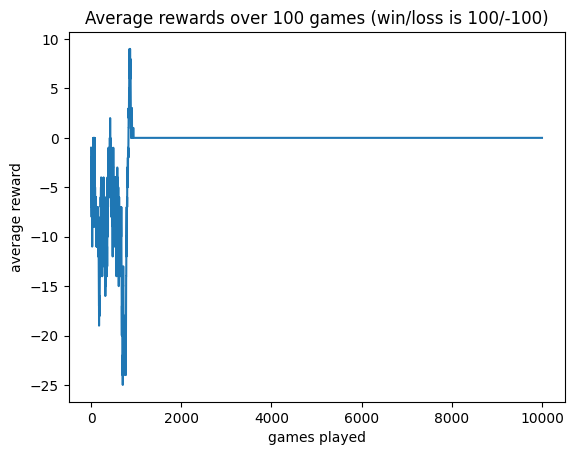

In [9]:
#max vs max
board = BoardEnvironment()
A = Agent(board, 'max')  # Change this line to make player A use the 'random' strategy
B = Agent(board, 'max')
board.set_players(A, B)

tournament = RepeatedGames(board, A, B)

# 1. Have them play 100 times (observe behavior prior to learning)
tournament.play_games(100)

# a. Then print how often each player wins or ties in these 100 games.
print()

# 2. Have them play 10,000 times.
tournament.play_games(10000)
print()

# a. Display a running average of the rewards player A receives.
import numpy as np
import pylab as py
import matplotlib
%matplotlib inline

history = np.array(tournament.history.copy())
rewards = np.zeros(len(history))
rewards[history == 'A'] = 100
rewards[history == 'B'] = -100

def running_mean(x, N):
    return np.convolve(x, np.ones((N,))/N, mode='valid')
r_mean = running_mean(rewards, 100)
py.plot(r_mean)
py.xlabel('games played')
py.ylabel('average reward')
py.title('Average rewards over 100 games (win/loss is 100/-100)')

# 3. Have them play 100 more times
tournament.play_games(100)

# a. Then print how often each player wins or ties in these 100 games
print()

# observe the highest and lowest board state action value functions
key_max = max(A.Q.keys(), key=(lambda k: A.Q[k]))
print("highest Q for player A:", A.Q[key_max],', state_action:', key_max)
board.print_board(key_max[0])
key_max = max(B.Q.keys(), key=(lambda k: B.Q[k]))
print("\nhighest Q for player B:", B.Q[key_max],', state_action:', key_max)
board.print_board(key_max[0])
key_min = min(A.Q.keys(), key=(lambda k: A.Q[k]))
print("\nlowest Q for player A:", A.Q[key_min],', state_action:', key_min)
board.print_board(key_min[0])
key_min = min(B.Q.keys(), key=(lambda k: B.Q[k]))
print("\nlowest Q for player B:", B.Q[key_min],', state_action:', key_min)
board.print_board(key_min[0])


Discussion for max vs max
In the max vs. random Tic Tac Toe tournament, player A (max policy) significantly outperformed player B (random policy), with 7498 wins in 10,000 games compared to 1273 wins for player B. The max vs. max tournament, however, had a very high number of ties (9298 in 10,000 games) and player B had a slight advantage, winning more games than player A. The state-action pairs revealed both players' learned strategies, with the highest and lowest Q-values corresponding to well-known winning tactics and unlearned strategies, respectively. The reward graph demonstrated a spike in player B's wins, which quickly flatlined after 1000 games, suggesting that both players had learned highly effective strategies. Overall, the results highlighted the importance of strong policies and the effectiveness of reinforcement learning in games with small state spaces like Tic Tac Toe.

Conclusion

The results from the three different policy match-ups in Tic Tac Toe reveal the effectiveness of reinforcement learning and strong policies in such games. In the max vs. random tournament, the max policy led to a clear advantage for player A, showcasing the value of a well-learned strategy. The random vs. random match-up resulted in no clear winner, as expected due to the lack of prioritization for winning or blocking the opponent. Lastly, the max vs. max tournament featured a high number of ties and only a slight advantage for player B, indicating that both players had learned highly effective strategies.

Overall, the study demonstrates the significant impact of reinforcement learning and strategic policy development in games with relatively small state spaces like Tic Tac Toe. Strong policies and the ability to adapt and learn from past experiences can greatly influence a player's success, underscoring the potential benefits of reinforcement learning in game-playing scenarios.